In [1]:
curr_dir = '/home/vayzenbe/GitHub_Repos/GiNN'

import sys
sys.path.insert(1, f'{curr_dir}/Models')
import os, argparse
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image, ImageOps,  ImageFilter
from itertools import chain
import pandas as pd
import numpy as np
import cornet
import model_funcs
from load_stim import load_stim
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats, mean
from IPython.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline


# Control rearing computational models

<img src= "presentation_files/rep_continuum.png" alt="drawing" width="800"/>

In [2]:
'''
Set folders and stim parameters
'''
########
#SELECT MODEL TYPE
model_type = 'classify'
########

stim_dir = f"{curr_dir}/Stim/"
weights_dir = f"/lab_data/behrmannlab/vlad/ginn/model_weights"
results_dir = f"{curr_dir}/Results/"



train_cond =['vggface','mixed_imagenet_vggface','imagenet_oneface','imagenet_objects_1','imagenet_objects']
train_cond =['imagenet_objects_1','mixed_imagenet_vggface','vggface']
n_classes = [600,  1200, 600]

#train_cond =['imagenet_objects', 'imagenet_objects_1']
#n_classes = [600, 600]
#train_cond = ['general']
#n_classes = [600]
#train_cond = ['imagenet_objects']
#model_types = ['vggface']
epochs = [0,1,5, 10, 15, 20, 25, 30]

layer = ['V1', 'V2', 'V4', 'pIT', 'aIT', 'out']
scaler = MinMaxScaler()

### Face inversion effect

<img src= "presentation_files/inversion_stim.jpg" alt="drawing" width="800"/>

In [3]:
def plot_preference(df_plot, df_conds):
    n= len(df_conds)
    colors = pl.cm.magma(np.linspace(0,.8,n))
    
    plt.figure()
    for dcn, dc in enumerate(df_conds):  
        coln = n - dcn-1
        plt.errorbar(df_plot['epoch'], df_plot[dc],  yerr=df_plot[f'{dc}_se'], label=dc, color = colors[coln])
    
  
    plt.xlabel("Epochs")
    plt.ylabel("Inversion Score")
    #ax.set_ylabel('Activation')
    #print(f'{df_plot["model][0]}-test')
    plt.title(f'{model_type} {df_plot["model"][0]} model with {df_plot["stim"][0]} stim')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    #plt.savefig(f'{curr_dir}/Results/inversion/figures/{df_plot["model"][0]}_{df_plot["stim"][0]}_{layer}.png',bbox_inches='tight')
    
    

In [4]:
def max_min_norm(vec1,vec2):
    """ takes two vectors and scales them between 0 and 1
    """
                    
    combined_vec = vec1.append(vec2)

    min_val = combined_vec.min()
    max_val = combined_vec.max()

    vec1_norm = (vec1 - min_val)/(max_val - min_val)
    vec2_norm = (vec2 - min_val)/(max_val - min_val)

    return vec1_norm, vec2_norm


In [5]:
def find_best(summary_df, curr_layer='out'):

    best_models =pd.DataFrame(columns = ['model', 'stim', 'epoch'] + layer + [s + '_se' for s in layer]) 
    for cc in im_cond:
        #Add random model first
        rand_model = summary_df[(summary_df['model'] == 'vggface') & (summary_df['epoch']  == 0) & (summary_df['stim']  == cc)]
        rand_model['model'] = 'random'
        rand_model[f'{curr_layer}_se'] += .01
        best_models= best_models.append(rand_model)
        for tc in train_cond:
            
            temp_df = summary_df[(summary_df['model'] == tc) & (summary_df['stim']  == cc) & (summary_df['epoch']  > 0)]
            #print(temp_df)
            temp_df = temp_df[temp_df[curr_layer] == np.max(temp_df[curr_layer])]
            best_models = best_models.append(temp_df)
            

        
        
        

    #Append random model
        
    return best_models

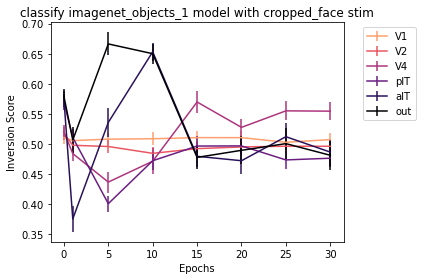

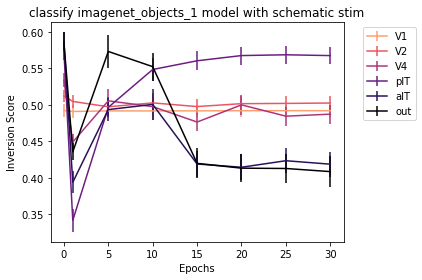

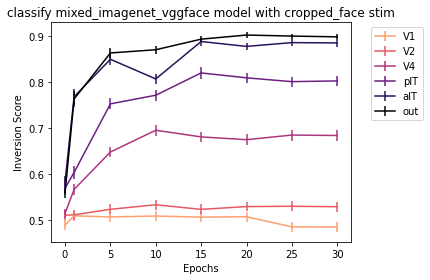

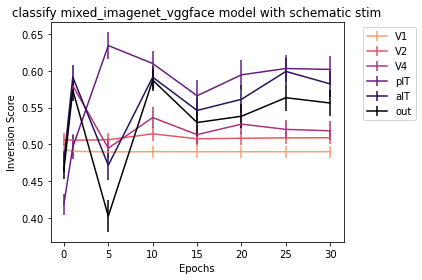

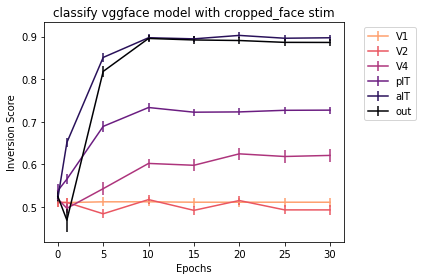

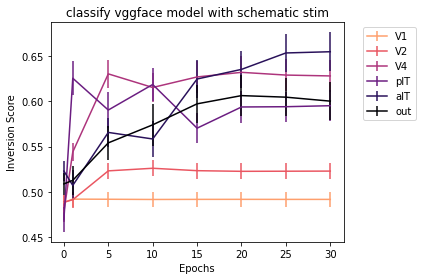

In [6]:
'''
Inversion Analysis loop
'''

im_cond = ['cropped_face', 'schematic']
all_model =pd.DataFrame(columns = ['model', 'stim', 'epoch'] + layer + [s + '_se' for s in layer]) 
for nc,mm in enumerate(train_cond):
    for cc in im_cond:
        im_dir = f'{stim_dir}/{cc}'
        #create summary file where the inversion ratio and SE for each layer is its own column
        summary_df =pd.DataFrame(columns = ['model', 'stim', 'epoch'] + layer + [s + '_se' for s in layer]) 
        
        for ee in epochs:
            ratio = []
            ratio_se =[]
            for ll in layer:

                df = pd.read_csv(f'{curr_dir}/Results/inversion/{model_type}_{mm}_{cc}_{ee}_{ll}.csv')

                upright, invert = max_min_norm(df['upright'],df['invert'])
                #upright, invert = df['upright'], df['invert']
                temp_ratio = upright / (upright +invert)
                ratio.append(temp_ratio.mean())
                ratio_se.append(temp_ratio.sem())
            
            temp_df = pd.Series([mm,cc, ee] +  ratio + ratio_se,index = summary_df.columns) 
            summary_df = summary_df.append(temp_df, ignore_index = True)
            #summary_df = summary_df.append({'model' : mm, 'stim' : cc, 'epoch' : ee, 
            #                                'upright' : upright.mean(), 'inverted' : invert.mean(),
            #                                'upright_se' : upright.sem() , 'inverted_se' : invert.sem(), 'ratio': ratio.mean(), 'ratio_se': ratio.sem() },ignore_index = True) 
            
        plot_preference(summary_df,layer)
        all_model = all_model.append(summary_df)



In [7]:
fig_cond = ['Blank-slate', 'General', 'Mixed', 'Face']
train_cond = ['random','imagenet_objects_1','mixed_imagenet_vggface','vggface']
best_model = find_best(all_model)
#best_model= best_model.append(all_model[(all_model['model'] == 'vggface') & (all_model['epoch']  == 0)])
best_model


/home/vayzenbe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/vayzenbe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/vayzenbe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,model,stim,epoch,V1,V2,V4,pIT,aIT,out,V1_se,V2_se,V4_se,pIT_se,aIT_se,out_se
0,random,cropped_face,0,0.511319,0.510413,0.519025,0.538418,0.520200,0.524925,0.010399,0.010433,0.010550,0.016525,0.011836,0.022714
2,imagenet_objects_1,cropped_face,5,0.508018,0.495796,0.436703,0.400808,0.535837,0.666268,0.010531,0.010627,0.017508,0.013313,0.023607,0.019202
5,mixed_imagenet_vggface,cropped_face,20,0.506864,0.528973,0.674716,0.809402,0.877858,0.902603,0.010622,0.010500,0.011749,0.011262,0.008433,0.005808
3,vggface,cropped_face,10,0.512248,0.517443,0.602329,0.733552,0.897349,0.895695,0.010426,0.010566,0.011410,0.010137,0.007951,0.008432
0,random,schematic,0,0.488206,0.488410,0.477941,0.469219,0.522935,0.508704,0.008427,0.008465,0.011404,0.013537,0.011083,0.022350
2,imagenet_objects_1,schematic,5,0.491674,0.497321,0.505469,0.496560,0.493458,0.573218,0.008449,0.010908,0.016502,0.013895,0.015819,0.023058
3,mixed_imagenet_vggface,schematic,10,0.490017,0.514306,0.536480,0.610183,0.591516,0.587505,0.008381,0.009435,0.013842,0.017433,0.015522,0.014939
5,vggface,schematic,20,0.491628,0.522634,0.632173,0.593839,0.635442,0.606412,0.008429,0.008770,0.017788,0.017304,0.020056,0.022417


/home/vayzenbe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


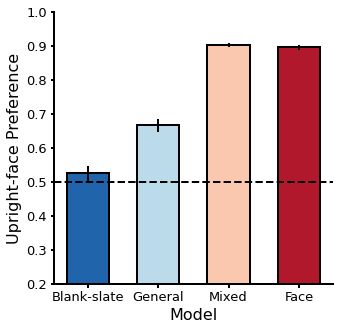

In [15]:
def plot_fit(summary_df,metric='out', save=False, filename=None, fig_cond=train_cond):
    
    
    width = .6  # the width of the bars

    colors = pl.cm.RdBu(np.flip(np.linspace(.1,.9,len(train_cond))))
    #colors = pl.cm.magma(np.linspace(0,.9,len(train_cond)))
    fig, ax = plt.subplots(figsize=(5,5))
    #offset =  [-2,-1,0,1,2]
    

    ax.bar(summary_df['model'], summary_df[metric], width, color = colors,edgecolor="black",linewidth =2)
        #labels = ax.bar(loc, epochs, width)
        #ax.text(loc, .8, s='0', ha='center', va='bottom')
    ax.errorbar(summary_df['model'], summary_df[metric], yerr =summary_df[f'{metric}_se'] ,color='black',linestyle='none', linewidth =2)



    
    ax.set_xticklabels(fig_cond)
    ax.axhline(.5, color='black', linestyle  = '--',linewidth =2)
    
    #ax.set_ylabel('Top-heavy Preference')
    plt.ylabel('Upright-face Preference', size = 16)
    plt.xlabel('Model', size = 16)
    ax.set_facecolor("white")
    ax.tick_params(axis='x', colors='black',width =2, labelsize=13)
    ax.tick_params(axis='y', colors='black',width =2,labelsize=13)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    for spine in ['bottom','left']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(2)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.ylim([.2,1])
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    if save == True:
        plt.savefig(f'{results_dir}/inversion/figures/{filename}.jpg',bbox_inches='tight', dpi = 300)
        

        
face_model = best_model[best_model['stim'] == 'cropped_face']
plot_fit(face_model,metric='out',  save=True, filename=f'inversion_best_models_face', fig_cond=fig_cond)

In [149]:
face_model

,model,stim,epoch,V1,V2,V4,pIT,aIT,out,V1_se,V2_se,V4_se,pIT_se,aIT_se,out_se
0,random,cropped_face,0,0.511319,0.510413,0.519025,0.538418,0.520200,0.524925,0.010399,0.010433,0.010550,0.016525,0.011836,0.012714
2,imagenet_objects_1,cropped_face,5,0.508018,0.495796,0.436703,0.400808,0.535837,0.666268,0.010531,0.010627,0.017508,0.013313,0.023607,0.019202
5,mixed_imagenet_vggface,cropped_face,20,0.506864,0.528973,0.674716,0.809402,0.877858,0.902603,0.010622,0.010500,0.011749,0.011262,0.008433,0.005808
3,vggface,cropped_face,10,0.512248,0.517443,0.602329,0.733552,0.897349,0.895695,0.010426,0.010566,0.011410,0.010137,0.007951,0.008432


### Viewpoint tolerance

<img src= "presentation_files/viewpoint_tolerance.jpg" alt="drawing" width="400"/>

In [6]:
def calc_acc(df, orient):
    #Calc front acc
    acc =[]
    same = df['similarity'][(df["identity"] == 'same') & (df["orient"] == 'diff')]
    diff = df['similarity'][(df["identity"] == 'diff') & (df["orient"] == 'diff')]
    
    same, diff = max_min_norm(same,diff)
    
    acc = same.mean()/(same.mean() + diff.mean())
    se = (same.sem() + diff.sem())/2
    
    same_acc, same_se = same.mean(), same.sem()
    diff_acc, diff_se = diff.mean(), diff.sem()
    
    ratio = same_acc / (same_acc + diff_acc)
    

    #for ss in same:
    #    for dd in diff:
    #        acc.append(dd/(ss+dd))   
    
    return acc, se,  same_acc, same_se, diff_acc, diff_se

In [7]:
def plot_dishabituation(df_plot, df_conds):
    n= len(df_conds)
    colors = pl.cm.magma(np.linspace(0,.8,n))
    #colors = np.flip(colors)
    
    plt.figure()
    for dcn, dc in enumerate(df_conds):    
        coln = n - dcn-1
        plt.errorbar(df_plot['epoch'], df_plot[dc],  yerr=df_plot[f'{dc}_se'], label=dc, color= colors[coln])
    
  
    plt.xlabel("Epochs")
    plt.ylabel("Recognition Score")
    #plt.ylim(.4, 1)
    #ax.set_ylabel('Activation')
    #print(f'{df_plot["model][0]}-test')
    plt.title(f'{df_plot["model_type"][0]} model trained with {df_plot["train_type"][0]}')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    #plt.savefig(f'{curr_dir}/Results/orientation/figures/{df_plot["model_type"][0]}_{df_plot["train_type"][0]}.png',bbox_inches='tight')
    

In [13]:
'''
Viewpoint invariance
Data plotting loop
'''

for tcn, tc  in enumerate(train_cond):
    summary_df = pd.DataFrame(columns = ['model_type', 'train_type', 'epoch']  + layer + [s + '_se' for s in layer])
    
    for ee in epochs:
        ratio = []
        ratio_se =[]
        for ll in layer:
            df = pd.read_csv(f'{curr_dir}/Results/orientation/{model_type}_{tc}_{ee}_{ll}.csv')
        
            acc, se,  same_acc, same_se, diff_acc, diff_se = calc_acc(df, 'same')
            ratio.append(acc)
            ratio_se.append(se)
        
    
        temp_df = pd.Series([df['model_type'][0],df['train_type'][0], df['epoch'][0]] +  ratio + ratio_se,
                            index = summary_df.columns) 
        summary_df = summary_df.append(temp_df, ignore_index = True)
    
    #break
    plot_dishabituation(summary_df, layer)
    
    
    

NameError: name 'calc_acc' is not defined

### Other species effect

<img src= "presentation_files/other_species.jpg" alt="drawing" width="400"/>

In [9]:
def calc_species_acc(df):
    #Calc front acc
    acc =[]
    same = df['test_loss'][(df["identity"] == 'same')]
    diff = df['test_loss'][(df["identity"] == 'diff')]

    for ss in same:
        for dd in diff:
            acc.append(dd/(ss+dd))   
    
    return pd.Series(acc).mean(), pd.Series(acc).sem()

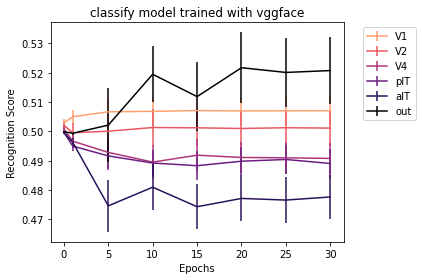

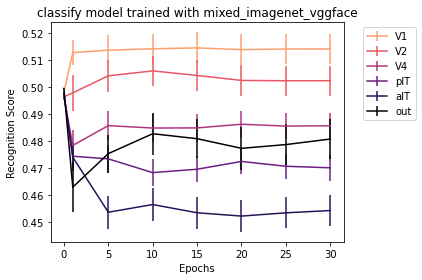

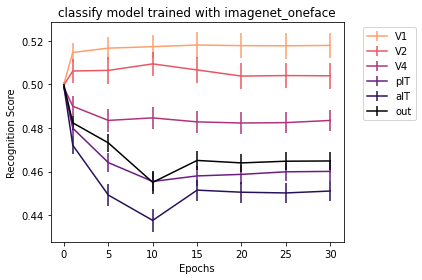

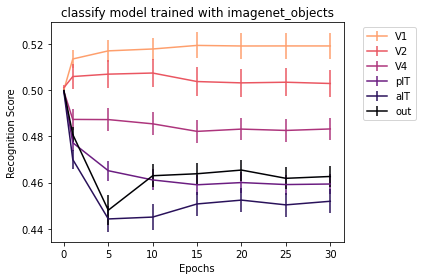

In [10]:
'''
Other-species
Data plotting loop
'''
for tcn, tc  in enumerate(train_cond):
    summary_df = pd.DataFrame(columns = ['model_type', 'train_type', 'epoch'] + layer + [s + '_se' for s in layer])
    for ee in epochs:
        ratio = []
        ratio_se =[]
        for ll in layer:
            df_monkey = pd.read_csv(f'{curr_dir}/Results/other_species/{model_type}_{tc}_{ee}_{ll}_monkey_front.csv')
            df_human = pd.read_csv(f'{curr_dir}/Results/other_species/{model_type}_{tc}_{ee}_{ll}_facegen_front.csv')

            #append front accuracy and SE
            monkey_acc, monkey_se = df_monkey['similarity'].mean(), df_monkey['similarity'].sem() 
            human_acc, human_se = df_human['similarity'].mean(), df_human['similarity'].sem()
            temp_ratio = monkey_acc/ (monkey_acc + human_acc)
            temp_se = (monkey_se + human_se )/ 2
            ratio.append(temp_ratio)
            ratio_se.append(temp_se)


        temp_df = pd.Series([df_monkey['model_type'][0],df_monkey['train_type'][0], df_monkey['epoch'][0]] + ratio + ratio_se,index = summary_df.columns) 
        summary_df = summary_df.append(temp_df, ignore_index = True)

    plot_dishabituation(summary_df, layer)


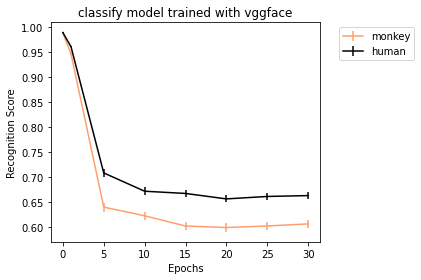

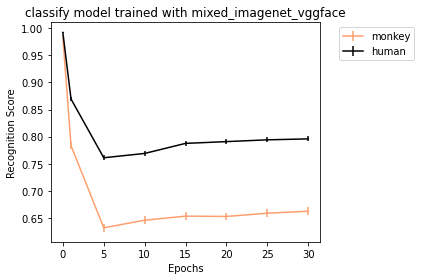

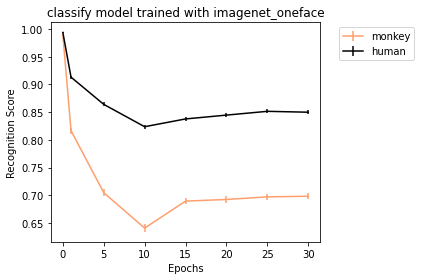

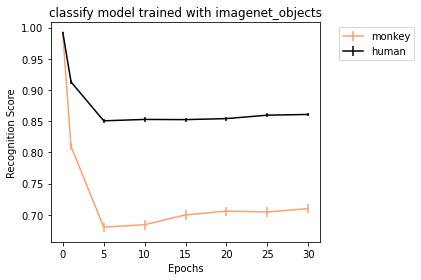

In [11]:
'''
Other-species
Data plotting loop
'''
ll = 'aIT'
for tcn, tc  in enumerate(train_cond):
    summary_df = pd.DataFrame(columns = ['model_type', 'train_type', 'epoch' ,
                                     'monkey', 'monkey_se', "human", "human_se"])
    for ee in epochs:
        ratio = []
        ratio_se =[]
        
        df_monkey = pd.read_csv(f'{curr_dir}/Results/other_species/{model_type}_{tc}_{ee}_{ll}_monkey_front.csv')
        df_human = pd.read_csv(f'{curr_dir}/Results/other_species/{model_type}_{tc}_{ee}_{ll}_facegen_front.csv')

        #append front accuracy and SE
        monkey_acc, monkey_se = df_monkey['similarity'].mean(), df_monkey['similarity'].sem() 
        human_acc, human_se = df_human['similarity'].mean(), df_human['similarity'].sem()



        temp_df = pd.Series([df_monkey['model_type'][0],df_monkey['train_type'][0], df_monkey['epoch'][0], 
                             monkey_acc, monkey_se, human_acc, human_se],
                            index = summary_df.columns) 
        summary_df = summary_df.append(temp_df, ignore_index = True)

    plot_dishabituation(summary_df, ['monkey', 'human'])
        